# PyTorch workflow basics

Import required modules

In [31]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
print(f"Torch version: {torch.__version__}")

Torch version: 2.0.1+cu118


Create the mock data set used by the rest of the code. (weight,bias) is the only model parameters used by the model used here. (lo, hi, step) are used to generates a set of points in the 2-dimensional space. The points are linear but diffused via a set of random numbers to simulate actual data.

The data set is split: 80% for training, 20% for testing.

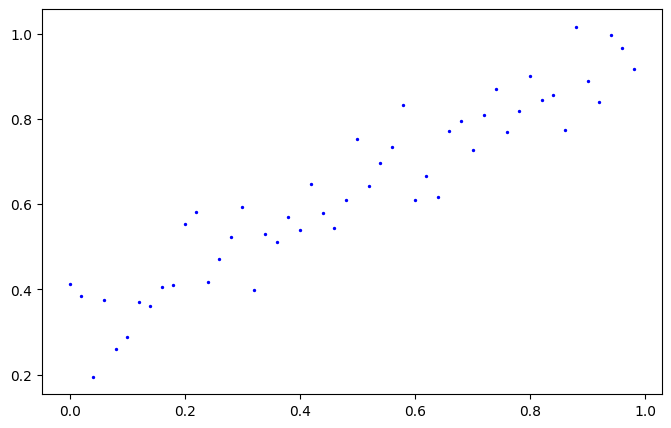

In [3]:
weight=0.7
bias=0.3
lo = 0
hi = 1
step = 0.02

X=torch.arange(lo,hi,step).unsqueeze(1)
y=X * weight + bias + torch.randn((int((hi-lo)/step + 0.5),1)) / 15
split = int(len(X) * 0.8)
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

plt.figure(figsize=(8,5))
plt.scatter(X, y, c='b', s=2)

Create a simple subclass of nn.Module as our linear regression model, with (weight,bias) as parameters.

Choose nn.L1Loss() as our loss function (to calculate the error of the model's output), and optim.SGD() as our optimizer for the model parameters. These are used in the training loop later.

L1Loss() calculates the total absolute difference between the model output and the labeled (known) y values of the train/test input. SGD(), stoichastic gradient descent, moves the model parameters (in this case, (wieght,bias)) in a calculated direction to reduce the loss in the next training epoch (iteration).

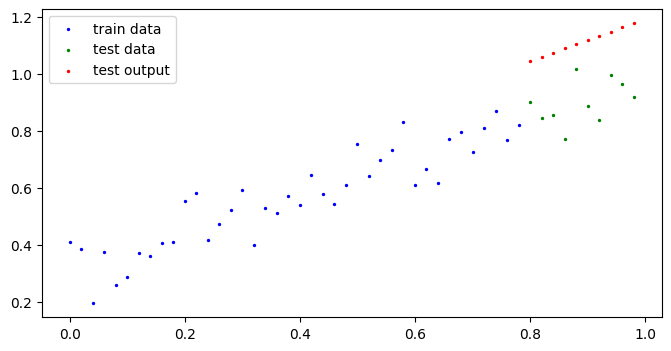

In [4]:
# simple model class:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    #nn.Module.__init__()
    super().__init__()
    self.weight = nn.Parameter(data=torch.rand(1, requires_grad=True, dtype=float))
    self.bias = nn.Parameter(data=torch.rand(1, requires_grad=True, dtype=float))

  def forward(self, x) -> torch.Tensor:
    return x * self.weight + self.bias

# prepare model, loss function, and optimizer
model = LinearRegressionModel()
loss_fn = nn.L1Loss()
#optim_fn = optim.ASGD(params=model.parameters(), lr=0.01)
optim_fn = optim.SGD(params=model.parameters(), lr=0.01)

# do a initial run of the test data, and plot it:
with torch.inference_mode():
  y_out = model(X_test)
plt.figure(figsize=(8,4))
plt.scatter(X_train,y_train,c="b",s=2, label='train data')
plt.scatter(X_test,y_test,c="g",s=2, label="test data")
plt.scatter(X_test, y_out, c="r",s=2, label="test output")
plt.legend()

Run the training loop. An epoch is an iteration through the entire training data set. The marked steps 0 thru 4 should be carried out in this order generally. The training and testing output during training is recorded in two arrays, and plotted along with the results.

OrderedDict([('weight', tensor([0.6686], dtype=torch.float64)), ('bias', tensor([0.2987], dtype=torch.float64))])


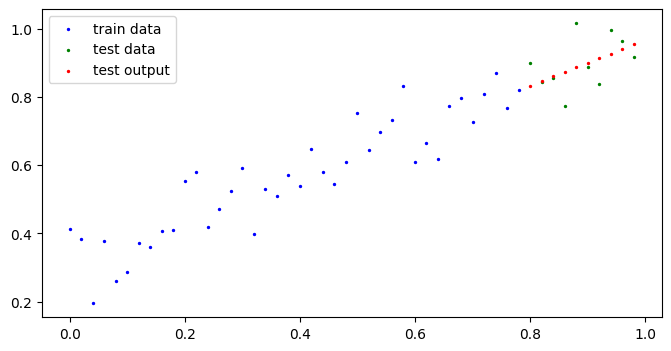

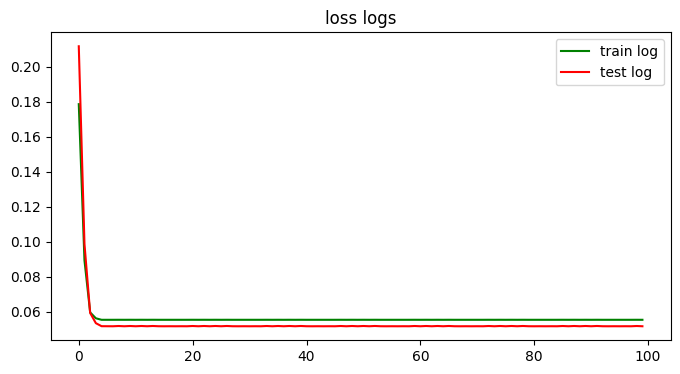

In [5]:
# run the model through training epochs
model.train()

test_log = []
train_log = []

epochs = 1000
for i in range(epochs):
  optim_fn.zero_grad() # 0. zero out accumulated gradient changes

  y = model(X_train) # 1. run trainig data through model
  loss = loss_fn(y, y_train) # 2. get the loss of this epoch

  # do logging:
  if i % (epochs//100) == 0:
    with torch.inference_mode():
      y_out = model(X_test) # run a test between training epochs
    test_log.append(float(loss_fn(y_out, y_test)))
    train_log.append(float(loss))

  loss.backward() # 3. back-propagate the loss
  optim_fn.step() # 4. let optimizer step the model Parameters along the gradient-descent

print(model.state_dict())

# test the trained model after training:
model.eval() # put model in eval mode
with torch.inference_mode():
  y_out = model(X_test)

# plot training logs and final results:
plt.figure(figsize=(8,4))
plt.scatter(X_train,y_train,c="b",s=2, label='train data')
plt.scatter(X_test,y_test,c="g",s=2, label="test data")
plt.scatter(X_test, y_out, c="r",s=2, label="output")
plt.legend()

plt.figure(figsize=(8,4))
plt.title('loss logs')
plt.plot(range(len(train_log)), train_log, c='g', label='train log')
plt.plot(range(len(test_log)), test_log, c='r', label='test log')
plt.legend()

To save a trained model to disk, save the model's state_dict(). It can be loaded into a newly created model via load_state_dict(), to bring the model to the trained state.

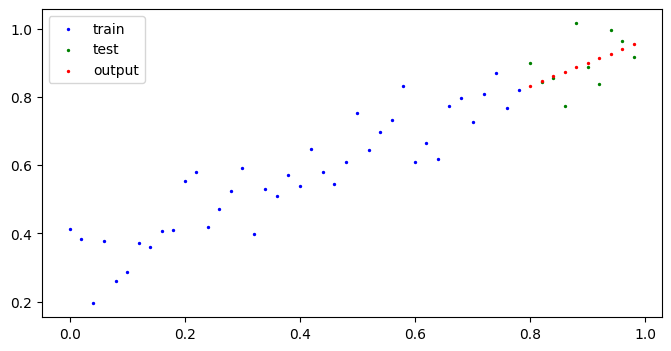

In [9]:
# save the state_dict of the trained model to a file
from pathlib import Path
file_dir = Path('./models')
file_dir.mkdir(parents=True, exist_ok=True)
file_name = 'my_model.pth'
torch.save(obj=model.state_dict(), f=file_dir/file_name)

# load the saved state_dict of the model into a new model2
model2 = LinearRegressionModel()
state_dict = torch.load(f=file_dir / file_name)
model2.load_state_dict(state_dict)

# run the test data through the new model2
model2.eval()
with torch.inference_mode():
  y_out2 = model2(X_test)

# plt the model2 output:
plt.figure(figsize=(8,4))
plt.scatter(X_train, y_train, c='b', s=2, label='train data')
plt.scatter(X_test, y_test, c='g', s=2, label='test data')
plt.scatter(X_test, y_out2, c='r', s=2, label='output')
plt.legend()